In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
from tqdm import trange

from agents.dqn import DoubleDQNAgent, QNetwork
from environment.env import GridEnvDeform, POMDPWrapper_v0, create_maze
import matplotlib.pyplot as plt

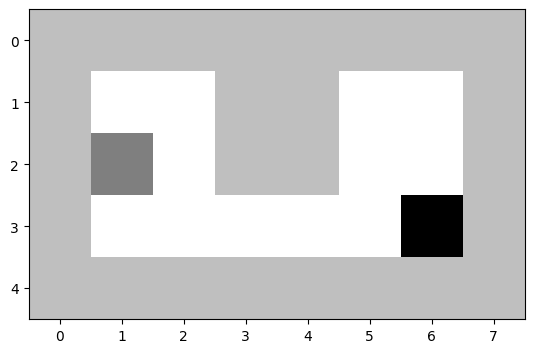

States: 144, Actions: 4, Observations 32, Thetas [(1, 1), (2, 1)]



In [2]:
# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 3
l1 = 1
h1 = 2

maze = np.load(f"maze/maze_{N}.npy")
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()

states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenA = len(actions)
lenO = len(obs)

print(f"States: {lenS}, Actions: {lenA}, Observations {lenO}, Thetas {thetas}\n")

T = torch.load(f"models/T_maze_{N}.pt", weights_only=True)
R = torch.load(f"models/R_maze_{N}.pt", weights_only=True)
O = torch.load(f"models/O_maze_{N}.pt", weights_only=True)


# fully observable train

notice that the train is fully observable, in the following cell each transition is \
(1) the current state \
(2) the action taken \
(3) the reward received \
(4) the next state \
(5) the done flag

where current state is an int (range(0, len(states)))

# tabular q-learning

In [10]:
from agents.tabular_qlearning import q_learning

Q = q_learning(env, 10000, 0.1, 0.95, 0.5, states_dict=state_dict)

np.save(f"agents/tabularQ_maze_{N}.npy", Q)

# Q = np.load(f"agents/tabularQ_maze_{N}.npy")

Episode 1/10000, Average Reward: 25.210084033613445
Episode 101/10000, Average Reward: 17.624748490945674
Episode 201/10000, Average Reward: -0.28762541806020064
Episode 301/10000, Average Reward: 25.489617486338798
Episode 401/10000, Average Reward: 26.252147766323024
Episode 501/10000, Average Reward: 25.762279888785912
Episode 601/10000, Average Reward: 30.1252
Episode 701/10000, Average Reward: 23.91588785046729
Episode 801/10000, Average Reward: 27.889306599832917
Episode 901/10000, Average Reward: 19.95421577515866
Episode 1001/10000, Average Reward: 31.22222222222222
Episode 1101/10000, Average Reward: 4.468838526912181
Episode 1201/10000, Average Reward: 26.882604562737644
Episode 1301/10000, Average Reward: 23.762200165425973
Episode 1401/10000, Average Reward: 32.145724258289704
Episode 1501/10000, Average Reward: 20.833517699115045
Episode 1601/10000, Average Reward: 24.4812
Episode 1701/10000, Average Reward: 17.252487562189053
Episode 1801/10000, Average Reward: 22.7706164

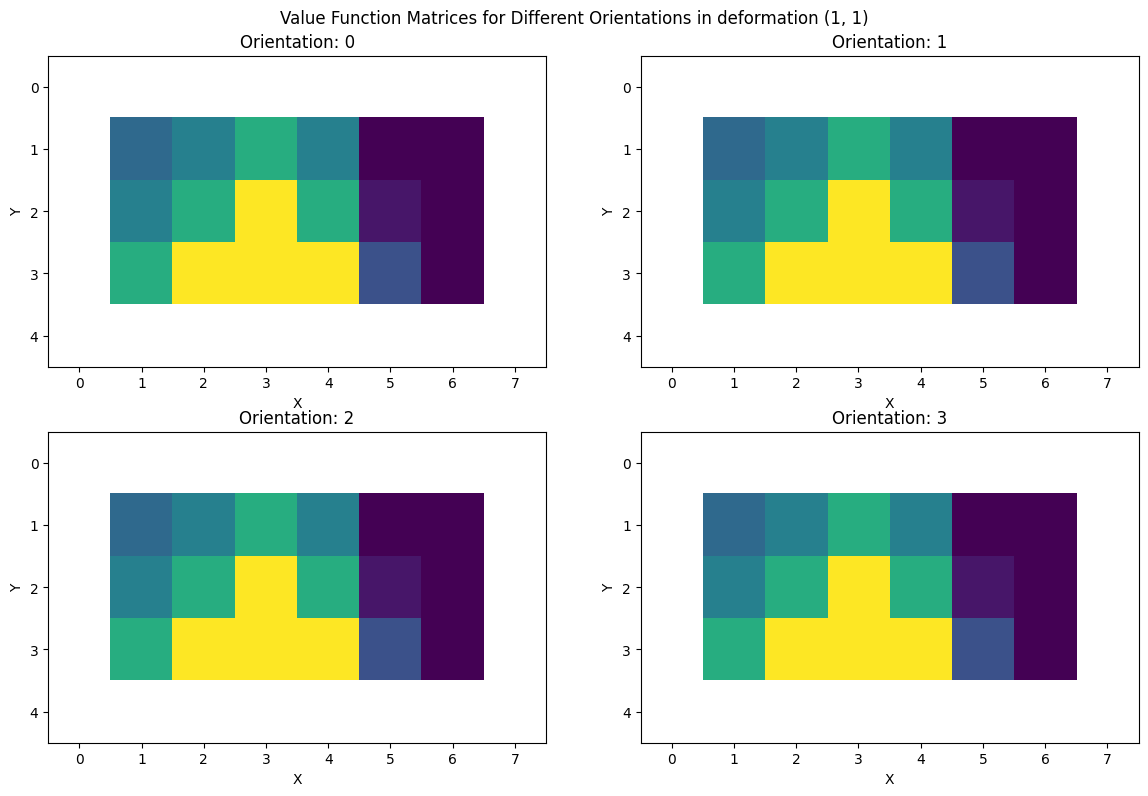

In [11]:
state_value = np.max(Q,axis=1)


# fix orientation and deformation
deformation = (1, 1)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for orientation in range(4):
    Value_matrix_plot = np.zeros(env.maze.shape) - np.inf
    for s, state in enumerate(states):
        if state[1] == deformation and state[0][2] == orientation:
            Value_matrix_plot[state[0][0], state[0][1]] = state_value[s]
    
    ax = axes[orientation]
    ax.imshow(Value_matrix_plot)
    ax.set_title(f"Orientation: {orientation}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.suptitle(f"Value Function Matrices for Different Orientations in deformation {deformation}")
plt.tight_layout()
plt.show()

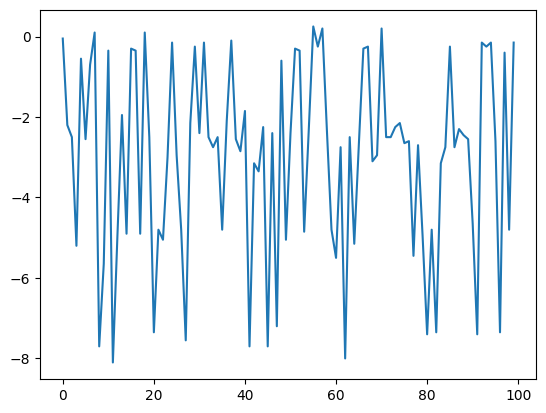

In [12]:
def eval_tabular(env : GridEnvDeform, Q, num_episodes=100, max_episode_steps=25, render=False):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = state_dict[s]

        episode_reward = 0
        done = False
        c = max_episode_steps
        while not done and c > 0:
            if render:
                env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = np.argmax(Q[state])
            if render:
                print(f"State: {s}, Action: {action}")
            next_state, reward, done, _, info = env.step(action.item(), s, execute=render)
            state = state_dict[next_state]
            s = next_state

            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

rewards = [eval_tabular(env, Q, 10) for _ in range(100)]  
plt.plot(rewards)

In [13]:
eval_tabular(env, Q, 1000)

np.float64(-2.6555)

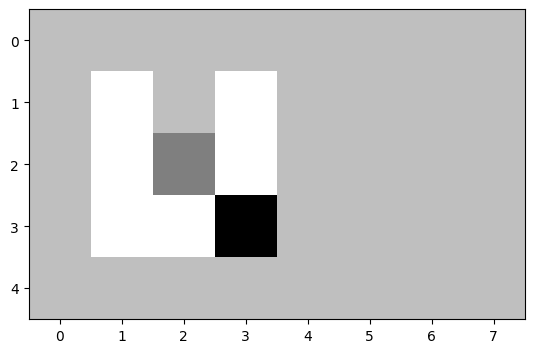

State: ((2, 2, 3), (1, 1)), Action: 2


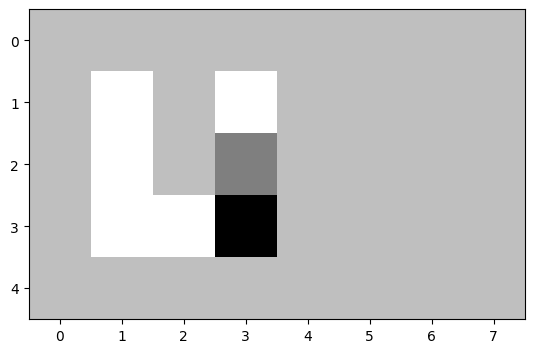

State: ((2, 3, 1), (1, 1)), Action: 1


np.float64(0.5)

In [38]:
eval_tabular(env, Q, 1, max_episode_steps=10, render=True)

## train Q network to approximate the tabular Q function

In [17]:
model = QNetwork(5, 4)
epochs = 100
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
criterion = nn.MSELoss()


Q = torch.tensor(Q,dtype=torch.float32)

# train the model
for epoch in range(epochs):
    for s, y in zip(states, Q[:]):
        x = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    
    scheduler.step()
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch} loss: {loss.item()}')    


Epoch 0 loss: 4.829005241394043
Epoch 5 loss: 1.6601293087005615
Epoch 10 loss: 0.6478246450424194
Epoch 15 loss: 0.4652237296104431
Epoch 20 loss: 0.49556124210357666
Epoch 25 loss: 0.6561330556869507
Epoch 30 loss: 0.4589766263961792
Epoch 35 loss: 0.5043449401855469
Epoch 40 loss: 0.42911437153816223
Epoch 45 loss: 0.3422735631465912
Epoch 50 loss: 0.18180051445960999
Epoch 55 loss: 0.1889575719833374
Epoch 60 loss: 0.16214816272258759
Epoch 65 loss: 0.10214663296937943
Epoch 70 loss: 0.08894090354442596
Epoch 75 loss: 0.078043133020401
Epoch 80 loss: 0.06742537766695023
Epoch 85 loss: 0.06477285921573639
Epoch 90 loss: 0.06779082119464874
Epoch 95 loss: 0.06679797917604446


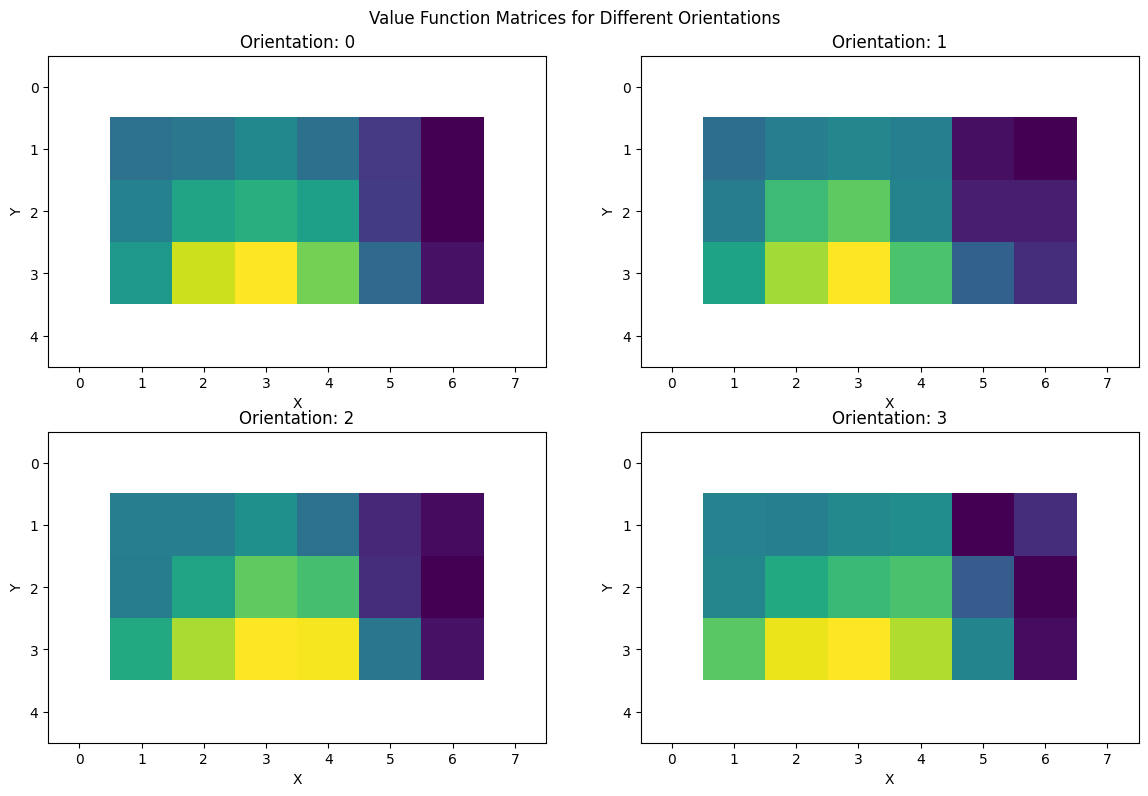

In [39]:
state_value = torch.zeros(lenS)
for s in range(lenS):
    state = torch.tensor([item for sublist in states[s] for item in sublist], dtype=torch.float32)
    state_value[s] = torch.max(model(state))


# fix orientation and deformation
deformation = (1, 1)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for orientation in range(4):
    Value_matrix_plot = np.zeros(env.maze.shape) - np.inf
    for s, state in enumerate(states):
        if state[1] == deformation and state[0][2] == orientation:
            Value_matrix_plot[state[0][0], state[0][1]] = state_value[s]
    
    ax = axes[orientation]
    ax.imshow(Value_matrix_plot)
    ax.set_title(f"Orientation: {orientation}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.suptitle("Value Function Matrices for Different Orientations")
plt.tight_layout()
plt.show()

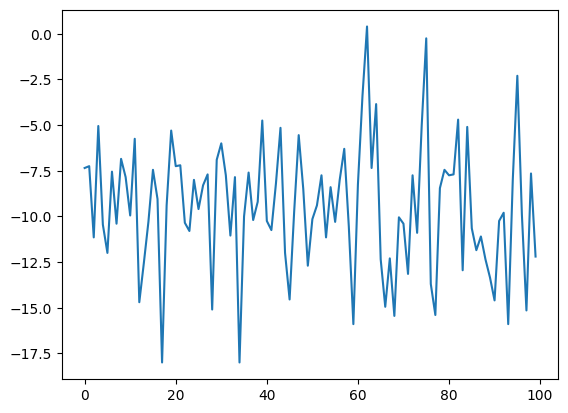

In [20]:
def evaluate_network(env : GridEnvDeform, model, num_episodes=10, max_episode_steps=25, render=False):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

        episode_reward = 0
        done = False
        c = max_episode_steps
        while not done and c > 0:
            # Render the environment
            if render:
                env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = torch.argmax(model(state))
            if render:
                print(f"State: {s}")
                print(f"Action: {action.item()}")
            
            next_state, reward, done, _, info = env.step(action.item(),s, execute = render)

            state = torch.tensor([item for sublist in next_state for item in sublist], dtype=torch.float32)
            s = next_state

            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

rewards = [evaluate_network(env, model, 10) for _ in range(100)]
plt.plot(rewards)


In [21]:
evaluate_network(env, model, 1000)

np.float64(-9.986)

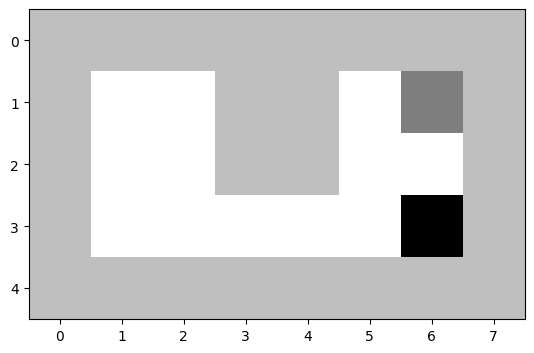

State: ((1, 6, 0), (2, 1))
Action: 2


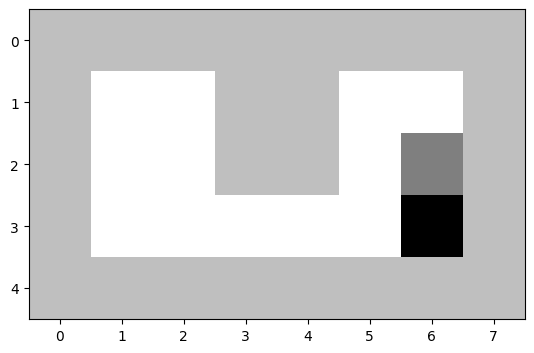

State: ((2, 6, 2), (2, 1))
Action: 0


np.float64(0.5)

In [42]:
evaluate_network(env, model, 1, max_episode_steps=10, render=True)

# train dqn 
optionally start with a pretrained model 

In [43]:
def evaluate_agent_training(env : GridEnvDeform, agent : DoubleDQNAgent, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

        episode_reward = 0
        done = False
        c = 25
        while not done and c > 0:
            # Render the environment
            # env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = agent.choose_deterministic_action(state)
            next_state, reward, done, _, info = env.step(action,s)

            state = torch.tensor([item for sublist in next_state for item in sublist], dtype=torch.float32)
            s = next_state

            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward


In [58]:
state_dim = 5
action_dim = 4

agent = DoubleDQNAgent(state_dim, action_dim, lr = 0.01)

In [59]:
num_episodes = 1000
max_episode_steps = 100

rewards = []
evalrewards = []

for episode in trange(num_episodes):
    s, _ = env.reset()
    state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

    
    episode_reward = 0
    done = False
    
    steps = 0
    while not done and steps < max_episode_steps:
        action = agent.choose_action(state)
        
        s_ , reward, done , _, _ = env.step(action,s, execute=True)
        next_state = torch.tensor([item for sublist in s_ for item in sublist], dtype=torch.float32)
        s = s_

        agent.store_transition(state, action, reward, next_state, done)

        agent.train()
        state = next_state
        episode_reward += reward
        steps += 1        
    
    agent.update_epsilon()
    rewards.append(episode_reward)
            
    
    if episode != 0 and episode % 5 == 0:
        avg_reward = evaluate_agent_training(env, agent)
        evalrewards.append(avg_reward)
        # print(f"Episode {episode + 1}/{num_episodes}, Average Reward: {avg_reward}")

print("Training complete.")
print("evalrewards: ", evalrewards)

100%|██████████| 1000/1000 [00:16<00:00, 60.07it/s]

Training complete.
evalrewards:  [np.float64(-26.4), np.float64(-16.65), np.float64(-11.5), np.float64(-6.95), np.float64(-2.35), np.float64(-0.75), np.float64(-0.95), np.float64(-0.55), np.float64(-0.9), np.float64(-1.55), np.float64(-6.6), np.float64(-0.85), np.float64(-1.7), np.float64(-0.5), np.float64(-0.6), np.float64(-0.95), np.float64(-5.35), np.float64(-0.55), np.float64(-1.05), np.float64(0.0), np.float64(-0.25), np.float64(-0.65), np.float64(-0.5), np.float64(-1.25), np.float64(-1.3), np.float64(-0.1), np.float64(-0.3), np.float64(-0.7), np.float64(-2.0), np.float64(-0.55), np.float64(-0.35), np.float64(-0.7), np.float64(-1.25), np.float64(-0.25), np.float64(-0.95), np.float64(-0.85), np.float64(-0.35), np.float64(-0.1), np.float64(-0.4), np.float64(0.25), np.float64(-0.5), np.float64(-0.25), np.float64(-0.6), np.float64(-0.25), np.float64(-1.15), np.float64(-0.45), np.float64(0.05), np.float64(-0.85), np.float64(-0.8), np.float64(-1.25), np.float64(-0.2), np.float64(-0.95),

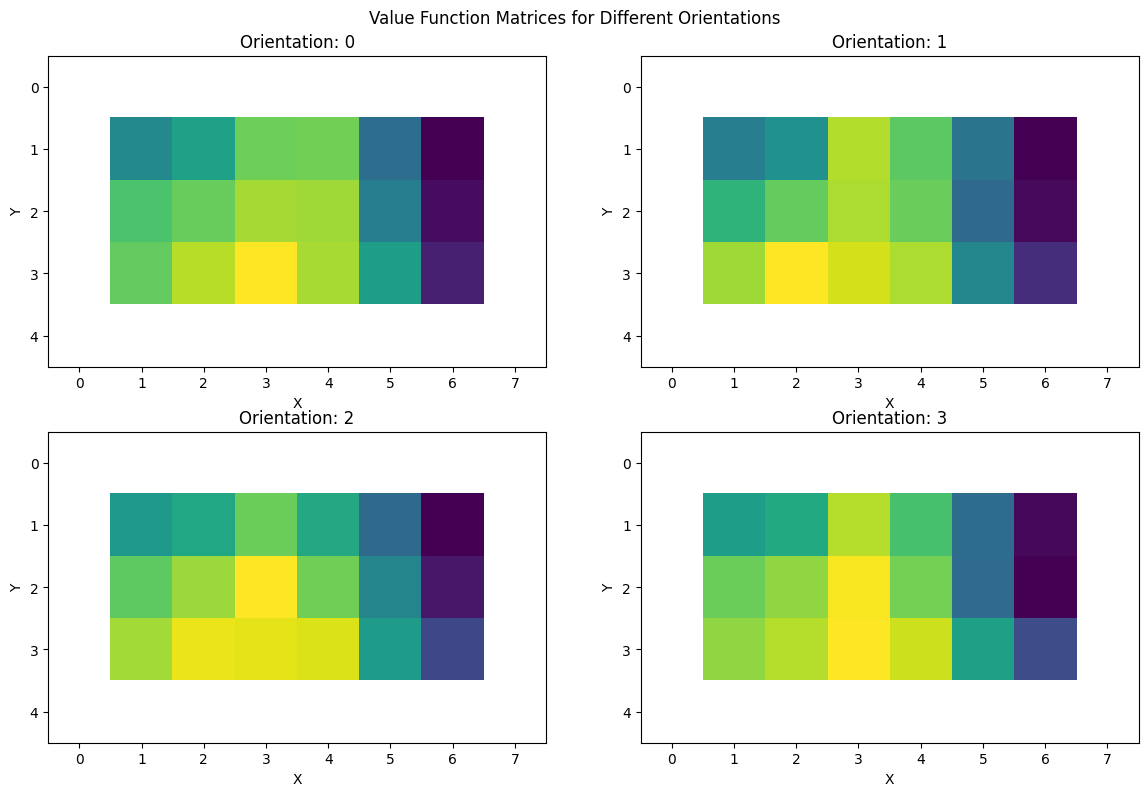

In [55]:
state_value = torch.zeros(lenS)
for s in range(lenS):
    state = torch.tensor([item for sublist in states[s] for item in sublist], dtype=torch.float32)
    state_value[s] = torch.max(agent.q_network(state))


# fix orientation and deformation
deformation = (1, 1)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for orientation in range(4):
    Value_matrix_plot = np.zeros(env.maze.shape) - np.inf
    for s, state in enumerate(states):
        if state[1] == deformation and state[0][2] == orientation:
            Value_matrix_plot[state[0][0], state[0][1]] = state_value[s]
    
    ax = axes[orientation]
    ax.imshow(Value_matrix_plot)
    ax.set_title(f"Orientation: {orientation}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.suptitle("Value Function Matrices for Different Orientations")
plt.tight_layout()
plt.show()

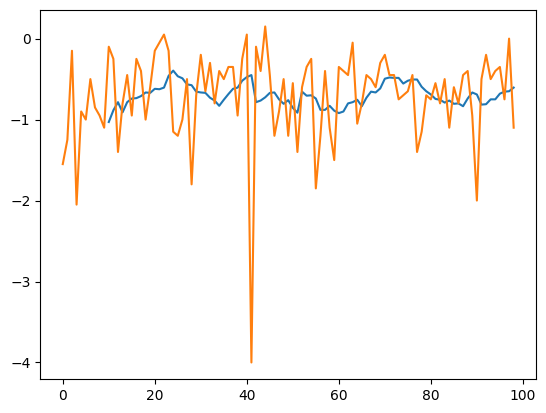

In [56]:
# plot evalrewards
rolling = [-np.inf for _ in range(10)] + [np.mean(evalrewards[i-10:i]) for i in range(10,len(evalrewards))]
plt.plot(rolling)
plt.plot(evalrewards)

In [57]:
evaluate_agent_training(env, agent, 1000)

np.float64(-0.5895)

# rendered evaluation


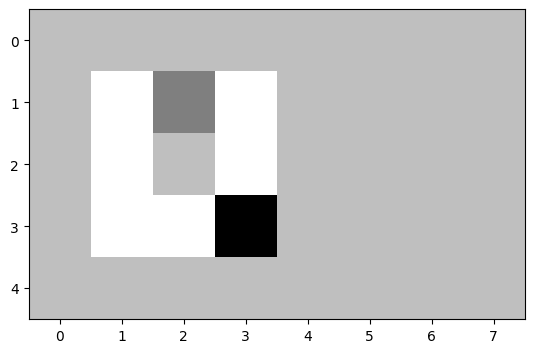

State: ((1, 2, 0), (1, 1))
Action: 1


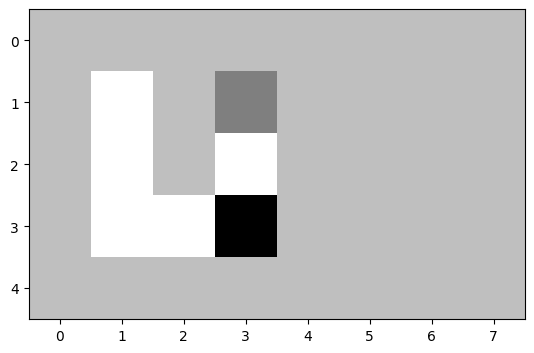

State: ((1, 3, 1), (1, 1))
Action: 1


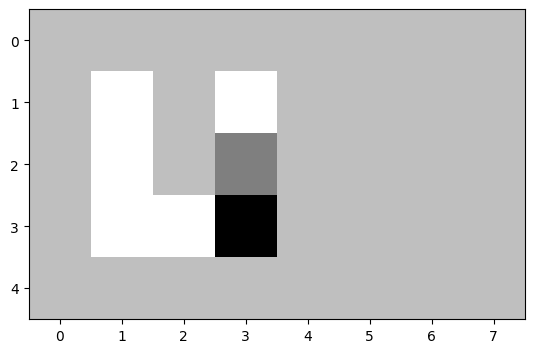

State: ((2, 3, 2), (1, 1))
Action: 0


np.float64(0.0)

In [64]:
def evaluate_agent_training(env : GridEnvDeform, agent : DoubleDQNAgent, num_episodes=10,max_episode_steps=25, render=False):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

        episode_reward = 0
        done = False
        c = max_episode_steps
        while not done and c > 0:
            if render:
                env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = agent.choose_deterministic_action(state)
            if render:
                print(f"State: {s}")
                print(f"Action: {action}")
            next_state, reward, done, _, info = env.step(action,s, execute=render)

            state = torch.tensor([item for sublist in next_state for item in sublist], dtype=torch.float32)
            s = next_state

            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

evaluate_agent_training(env, agent, 1, render=True)

# transition check

In [ ]:
env_wrapper = POMDPWrapper_v0(env, agent, T, O, R)

In [9]:
# copy what is done in training:
# start from a random state chose an action and store the transition 
state, _ = env_wrapper.reset()
action = agent.choose_action([state])

obs, reward, done, info = env_wrapper.step(state, action)
next_state = info['actual_state'] # next true state (not observation or belief)

agent.store_transition([state], action, reward, [next_state], done)
state, action, reward, next_state, done


(109, 0, -1.0, 109, False)

In [41]:
state = ((1., 6., 0.),(1., 1.))
action = 3

In [43]:
state_dict[state]

40

In [45]:
state = 40

In [50]:
next_state = ((1., 5., 3.),(1., 1.))
next_state = state_dict[next_state]

((1, 6, 0), (1, 1))


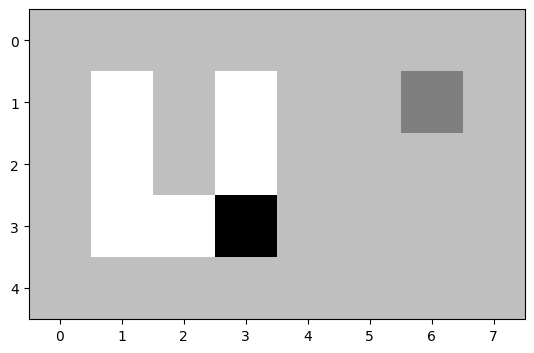

(((1, 5, 3), (1, 1)), -2, np.False_, False, {})


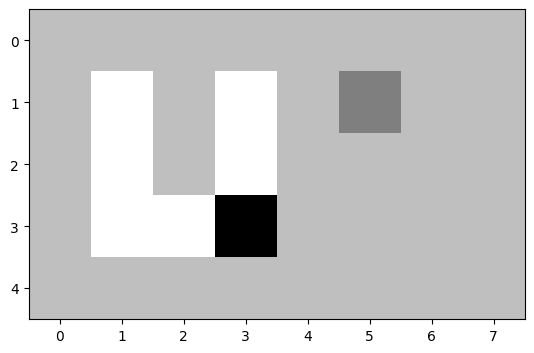

Training transition is correct


In [52]:
# set state and render
env.set_state(states[state])
print(states[state])
env.render()

# step and render
print(env.step(action, states[state], execute=True))
env.render()

# check if the transition is correct
assert env.get_state() == states[next_state]
print("Training transition is", "correct" if env.get_state() == states[next_state] else "incorrect")

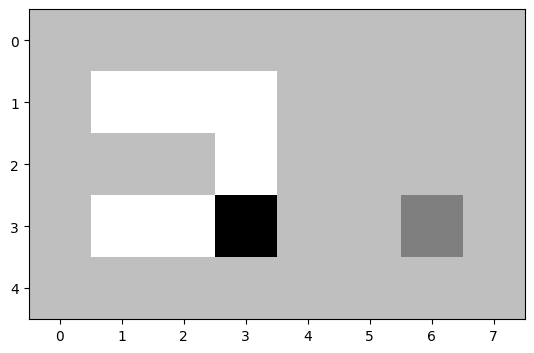

In [23]:
maze = create_maze(N)
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()